### Intro to Gaussian Processes (from Scratch)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

### Sampling from Prior

In [2]:
def kernel(x, xp):
    '''k(x,x') = sigma^2 exp(-0.5*length^2*|x-x'|^2)'''
    σ = 1
    length = 1
    sq_norm = scipy.spatial.distance.cdist(x, xp, 'sqeuclidean')
    return σ**2 * np.exp(-0.5*sq_norm*length**2)

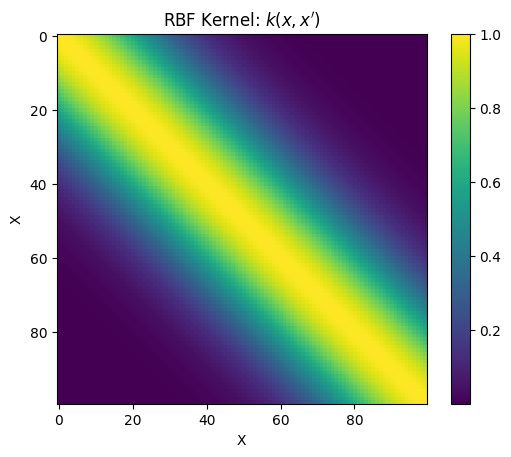

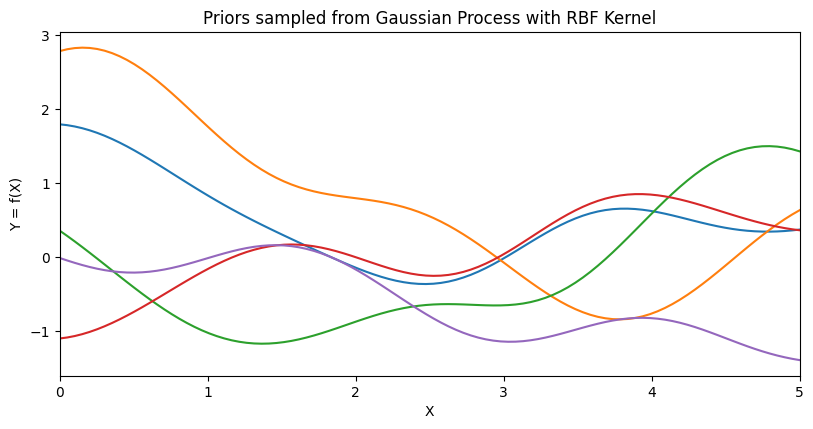

In [3]:
# Sample from Gaussian Process Distribution
pts = 100 # number of points in each function
n = 5 # number of functions to sample

# Independent Variable Samples
X = np.linspace(0,5, pts)
X = X.reshape(-1,1)
Σ = kernel(X,X)
fx = np.random.multivariate_normal(mean = np.zeros(pts), cov = Σ, size = n)

plt.title('RBF Kernel: $k(x,x\')$')
plt.imshow(Σ, cmap = 'viridis')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('X')
plt.show()

plt.figure(figsize=(8,4))
for i in range(n):
    plt.plot(X, fx[i])


plt.tight_layout()
plt.xlim(0,5)
plt.xlabel('X')
plt.ylabel('Y = f(X)')
plt.title('Priors sampled from Gaussian Process with RBF Kernel')
plt.show()

### Prediction from Posterior

In [4]:
def posterior(X1, y1, X2, kernel, noise = None, samples = None):
    '''
    Compute posterior mean and covariance i.e. mu_(2|1) and cov_(2|1)
    y1 = f(x1)
    '''
    Σ11 = kernel(X1, X1)

    if noise is not None:
        err = (noise**2) * np.eye(Σ11.shape[0])
        Σ11 += err
        
    Σ22 = kernel(X2, X2)
    Σ12 = kernel(X1, X2)

    sol = scipy.linalg.solve(Σ11, Σ12, assume_a = 'pos').T
    #μ1 = np.mean(y1)
    μ1 = 0 # assume prior mean is 0
    μ2 = np.mean(X2)

    μ = μ2 + sol @ (y1 - μ1)
    Σ = Σ22 - (sol @ Σ12)

    return μ, Σ   

In [5]:
# Define the true function
f_sin = lambda x: (np.sin(x)).flatten()
n1 = 10 # number of points to condition on (training points)
n2 = 70 # number of points in posterior (test points)
ny = 5 # number of functions that will be sampled from posterior

# Sample observations
X1 = np.random.uniform(-4, 4, size = (n1, 1))
y1 = f_sin(X1)

# Predict points at uniform spacing to capture funciton
X2 = np.linspace(-6, 6, n2).reshape(-1,1)

# Compute posterior mean and covariance
μ2_1, Σ2_1 = posterior(X1, y1, X2, kernel = kernel, noise = 0.2, samples = n1)

# Compute standard deviation at test points to be plotted
σ2 = np.sqrt(np.diag(Σ2_1))

# Draw some samples from the posterior
y2 = np.random.multivariate_normal(mean = μ2_1, cov = Σ2_1, size = ny)

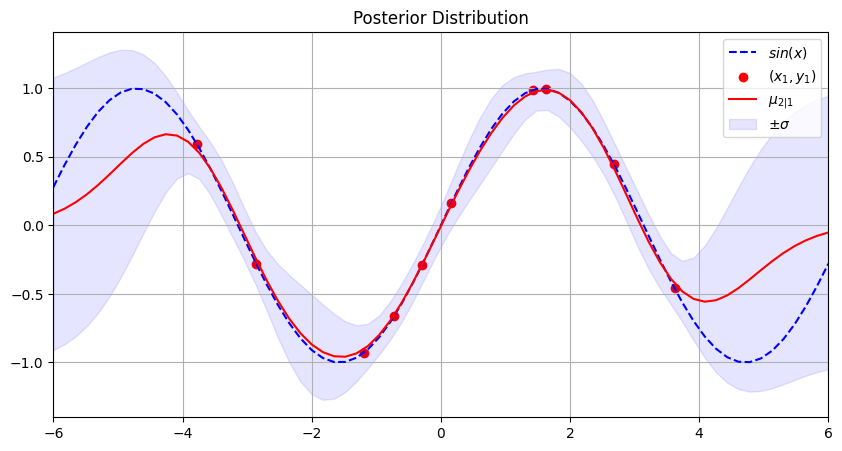

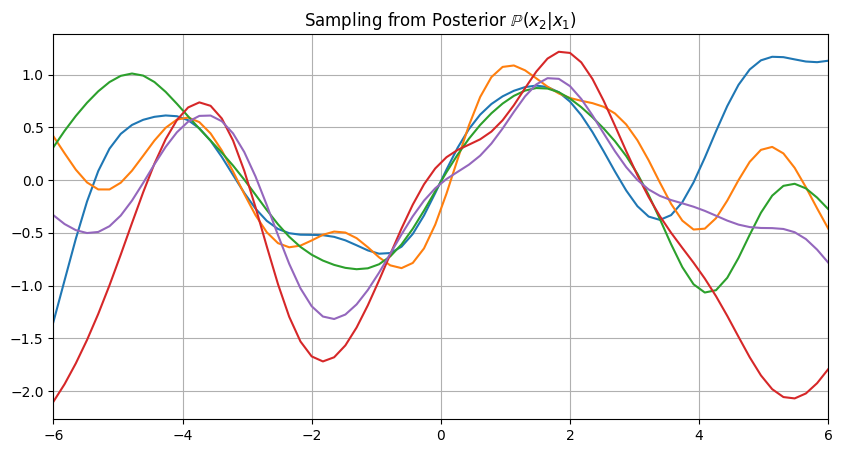

In [6]:
plt.figure(figsize=(10,5))
plt.plot(X2, f_sin(X2), 'b--',label = '$sin(x)$')
plt.scatter(X1, y1, color = 'red',label = '($x_1, y_1$)')
plt.plot(X2, μ2_1, color = 'red', label = '$\mu_{2|1}$')
plt.fill_between(X2.flatten(), μ2_1 - σ2, μ2_1 + σ2, color = 'blue', alpha = 0.1, label = '$\pm \sigma$')
plt.plot()
plt.legend()
plt.xlim(-6,6)
plt.title('Posterior Distribution')
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.title('Sampling from Posterior $\mathbb{P}(x_2|x_1)$')
plt.plot(X2, y2.T)
plt.xlim(-6,6)
plt.grid()
plt.show()

#### Marginal Likelihood

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

def kernel(x, xp, σ, l):
    '''k(x,x') = sigma^2 exp(-0.5*length^2*|x-x'|^2)'''
    length = l
    sq_norm = (scipy.spatial.distance.cdist(x, xp))**2
    return σ**2 * np.exp(-0.5*sq_norm/(length**2))

def dKdL(x1, x2, σ, l):
    '''
    computes partial derivative of K w.r.t length (l)
    arg: x1 = (N1, D), x2 = (N2, D)
    return: (N1, N2)
    '''
    sq_norm = (scipy.spatial.distance.cdist(x1, x2))**2
    return (-σ**2 * sq_norm / l**3) * np.exp(-sq_norm/(2*l**2))

def dKdσ(x1, x2, σ, l):
    '''
    computes partal derivatice of K w.r.t sigma (std not variance)
    arg: x1 = (N1, D), x2 = (N2, D)
    return: (N1, N2)
    '''
    sq_norm = (scipy.spatial.distance.cdist(x1, x2))**2
    return -2*σ*np.exp(-sq_norm/(2*l**2))

def dLdt(a, iKxx, dKdt):
    '''
    computes gradient of log marginal likelihood w.r.t. a hyper-parameter
    i.e. either sigma or length
    '''
    #return 0.5*np.trace(np.dot(a @ a.T - iKxx, dKdt))
    return 0.5 * np.trace((np.outer(a, a) - iKxx) @ dKdt)
    
def f_opt(kernel, X, y, σ, l):
    '''
    Evalaute Negative-Log Marginal Likelihood
    '''
    σ_n = 0.1 # std of noise hard-coded for now
    K = kernel(X,X, σ = σ, l = l) + (σ_n**2)*np.eye(X.shape[0])
    L = np.linalg.cholesky(K) + 1e-12                   # Cholesky decomposition
    a = np.linalg.solve(L.T, np.linalg.solve(L, y))     # compute alpha

    #log_likelihood = -0.5 * y.T @ a - 0.5 * np.trace(np.log(L)) - 0.5 * X.shape[0] * np.log(2*np.pi)
    log_likelihood = -0.5 * y.T @ a - 0.5 * np.log(np.linalg.det(K)) - 0.5 * X.shape[0] * np.log(2*np.pi)

    return -log_likelihood

def grad_f(params, X, y):
    '''
    Compute gradient of objective function w.r.t. two parameters
    '''
    l, σ = params
    σ_n = 0.1 # std of noise hard-coded for now
    K = kernel(X,X, σ = σ, l = l) + (σ_n**2)*np.eye(X.shape[0])
    L = np.linalg.cholesky(K) + 1e-12# Cholesky decomposition
    a = np.linalg.solve(L.T, np.linalg.solve(L, y))  # compute alpha

    inv_k = np.linalg.inv(K)

    #print ('dKdsigma:', dKdσ(X, X, σ, l))
    #print ('dKdlength:', dKdL(X, X, σ, l))

    grad = np.empty([2,])
    grad[0] = dLdt(a = a, iKxx = inv_k, dKdt = dKdL(X, X, σ, l))  # gradient w.r.t length
    grad[1] = dLdt(a = a, iKxx = inv_k, dKdt = dKdσ(X, X, σ, l))  # gradient w.r.t sigma

    return grad

def marginal(params, X, y):
    '''
    Evalaute Negative-Log Marginal Likelihood
    '''
    #print (params)
    l, σ = params
    σ_n = 0.1 # std of noise hard-coded for now
    K = kernel(X, X, σ = σ, l = l) + (σ_n**2)*np.eye(X.shape[0])
    L = np.linalg.cholesky(K) + 1e-12                   # Cholesky decomposition
    a = np.linalg.solve(L.T, np.linalg.solve(L, y))     # compute alpha

    #log_likelihood = -0.5 * y.T @ a - 0.5 * np.trace(np.log(L)) - 0.5 * X.shape[0] * np.log(2*np.pi)
    log_likelihood = -0.5 * y.T @ a - 0.5 * np.log(np.linalg.det(K)) - 0.5 * X.shape[0] * np.log(2*np.pi)

    return -log_likelihood          # negating since we are minimizing

#### Standard Finite Difference Method

In [8]:
def numerical_gradient(f, params, h = 1e-5):
    num_grad = np.zeros_like(params)
    for i in range(len(params)):
        params_plus_h = np.copy(params)
        params_minus_h = np.copy(params)
        
        params_plus_h[i] += h
        params_minus_h[i] -= h
        
        num_grad[i] = (f(params_plus_h, X, y) - f(params_minus_h, X, y)) / (2 * h)
    
    return num_grad

# Example usage:
f_sin = lambda x: (np.sin(x)).flatten()
X = np.random.uniform(-4, 4, size=(10, 1))
y = f_sin(X)

# Test the gradient function
params = np.array([3, 0.5])
print("Analytical gradient:", grad_f(params, X, y))
print("Numerical gradient:", numerical_gradient(marginal, params))

Analytical gradient: [ 43.39684382 -97.34301297]
Numerical gradient: [ 43.39684382 -97.34301298]


In [9]:
lim = [1.0, 10**3]
bound = [lim, lim]
start = [10, 10]   # initial hyper-parameter
result = scipy.optimize.minimize(fun = marginal, x0 = start, args = (X, y), jac = grad_f, method = 'SLSQP', options = {'disp':True}, bounds = bound, tol = 0.01)
result1 = scipy.optimize.minimize(fun = marginal, x0 = start, args = (X, y), method = 'SLSQP', options = {'disp':True}, bounds = bound, tol = 0.01)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5876944012822864
            Iterations: 11
            Function evaluations: 15
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5877305845003136
            Iterations: 11
            Function evaluations: 37
            Gradient evaluations: 11


In [10]:
print (result)
print ('')
print (result1)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.5876944012822864
       x: [ 1.760e+00  1.000e+00]
     nit: 11
     jac: [ 4.472e-01  3.631e-02]
    nfev: 15
    njev: 11

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.5877305845003136
       x: [ 1.761e+00  1.000e+00]
     nit: 11
     jac: [ 4.555e-01  2.928e-02]
    nfev: 37
    njev: 11


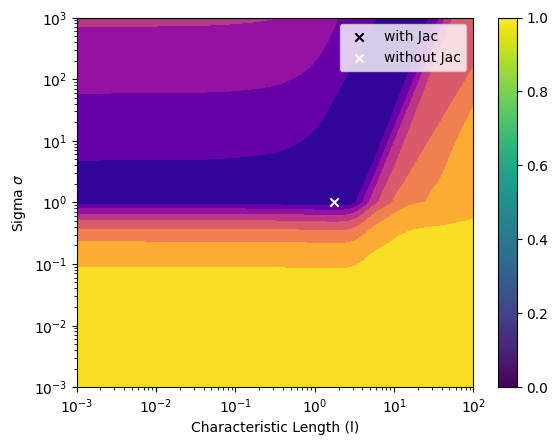

In [11]:
L = np.linspace(10**-3, 10**2, 1000)
S = np.linspace(10**-3, 10**3, 1000)
σ, l = np.meshgrid(L, S)

func_val = np.zeros_like(σ)

for i in range(σ.shape[0]):
    for j in range(l.shape[0]):
        func_val[i, j] = f_opt(kernel = kernel, X = X.reshape(-1,1), y = y.reshape(-1,1), σ = S[i], l = L[j])

plt.contourf(σ, l, func_val, cmap = 'plasma')
plt.xscale('log')
plt.yscale('log')
plt.scatter(result.x[0], result.x[1], color = 'black', marker = 'x', label = 'with Jac')
plt.scatter(result1.x[0], result1.x[1], color = 'white', marker = 'x', label = 'without Jac')
plt.colorbar()
plt.xlabel('Characteristic Length (l)')
plt.ylabel('Sigma $\sigma$')
plt.legend()
plt.show()

## MCMC Sampling

In [12]:
import numpy as np

def metropolis_hastings(target_density, proposal_density, num_samples, initial_state, burn_in=1000):
    """
    Metropolis-Hastings algorithm for sampling from a target density using a proposal density.

    Parameters
    ----------
    target_density : function
        The target probability density function.
    proposal_density : function
        The proposal probability density function.
    num_samples : int
        The number of samples to generate.
    initial_state : float or array_like
        The initial state of the Markov chain.
    burn_in : int, optional
        The number of samples to discard at the beginning of the chain as burn-in.

    Returns
    -------
    samples : array_like
        The generated samples.
    acceptance_rate : float
        The acceptance rate of the Metropolis-Hastings algorithm.
    """
    samples = [initial_state]
    all_samples = [initial_state]
    num_accepted = 0

    current_state = initial_state
    for i in range(num_samples + burn_in):

        proposed_state = proposal_density(current_state)
        hasting_ratio = proposal_density(current_state) / proposal_density(proposed_state)
        metropolis_ratio = target_density(proposed_state) / target_density(current_state)
        ratio = metropolis_ratio*hasting_ratio
        acceptance_prob = min(ratio, 1)

        if np.random.rand() < acceptance_prob:
            current_state = proposed_state
            num_accepted += 1

        if i >= burn_in:
            samples.append(current_state)
    
        all_samples.append(current_state)

    acceptance_rate = num_accepted / num_samples

    return samples, acceptance_rate, all_samples


In [13]:
def gaussian(x):
    return 0.5*(1 / np.sqrt(2 * np.pi * 1**2) * np.exp(-(x + 2)**2 / (2 * 1**2))) + 0.5 *(1 / np.sqrt(2 * np.pi * 1**2) * np.exp(-(x - 2)**2 / (2 * 1**2)))
    #return np.exp(-0.5 * ((x - 3) / 0.8)**2) + np.exp(-0.5 * ((x + 1) / 1.2)**2)
    

def proposal(x):
    return np.random.normal(x, 1)


target = lambda x: gaussian(x)
proposal = proposal

samples, acceptance_rate, all_samples = metropolis_hastings(target, proposal, 10000, initial_state=0)

print(f"Acceptance rate: {acceptance_rate:.3f}")
print(f"Mean: {np.mean(samples):.3f}")
print(f"Standard deviation: {np.std(samples):.3f}")

Acceptance rate: 0.594
Mean: -0.177
Standard deviation: 1.905


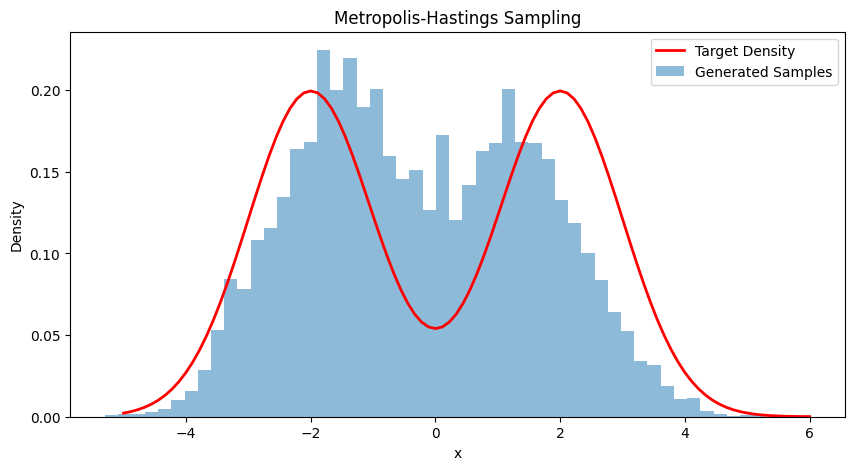

In [14]:
import matplotlib.pyplot as plt

# Generate samples
samples, acceptance_rate, all_samples = metropolis_hastings(target, proposal, 10000, initial_state=0)

# Plot true target density
x = np.linspace(-5, 6, 100)
plt.figure(figsize=(10,5))
plt.plot(x, target(x), color='red', linewidth=2)

# Plot histogram of samples
plt.hist(samples, bins=50, density=True, alpha=0.5)

plt.xlabel('x')
plt.ylabel('Density')
plt.title('Metropolis-Hastings Sampling')
plt.legend(['Target Density', 'Generated Samples'])
plt.show()

In [15]:
def kernel(X1, X2, theta):
    """
    Computes the RBF kernel matrix between two sets of input vectors X1 and X2.
    
    Args:
        X1: A numpy array of shape (n1, d), representing the first set of input vectors.
        X2: A numpy array of shape (n2, d), representing the second set of input vectors.
        lengthscale: The lengthscale parameter of the RBF kernel.
        variance: The variance parameter of the RBF kernel.
    
    Returns:
        A numpy array of shape (n1, n2), representing the RBF kernel matrix.

    Formula:
        dist_sq = ||X1 - X2.T||^2
                = ||X1||^2 + ||X2||^2 - 2*X1*X2.T
    """
    variance, lengthscale = theta
    dist_sq = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2*np.dot(X1, X2.T)
    K = variance * np.exp(-0.5 * dist_sq / (lengthscale ** 2))
    return K    

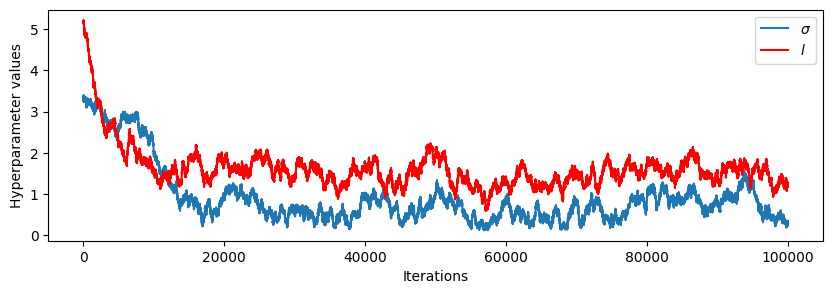

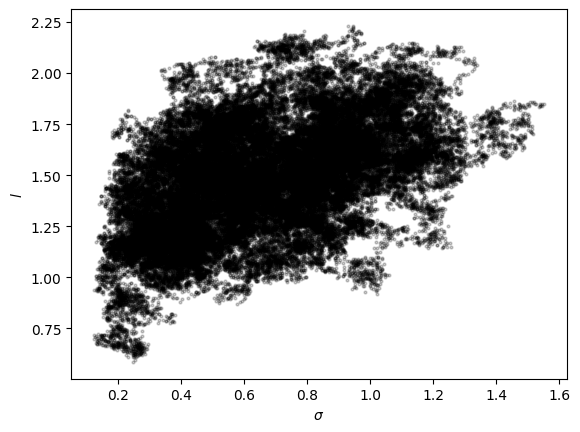

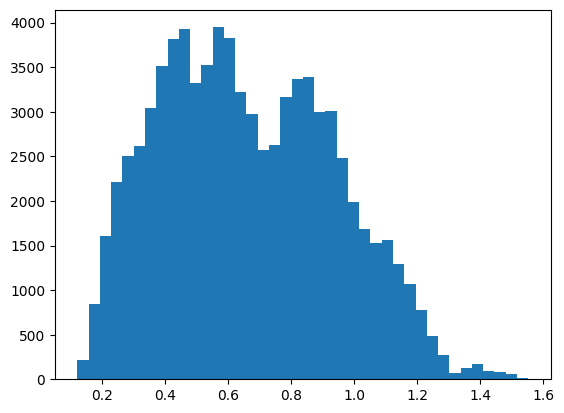

In [16]:
def mcmc_main_function(hyperparameters_i, iters, seed_value, noise_variance, X, y): 

    np.random.seed(seed_value)
    number_of_priors = 2
    jitter = 1e-4
    eta = np.diag(np.ones((number_of_priors))) * jitter
    accepted_counter = 0

    # Go through loop!
    counter = 0
    hyp_store = np.zeros((iters, 2))
    for i in range(iters):
        unnormalized_post_i = unnormalized_posterior(hyperparameters_i, noise_variance, X, y)
        hyperparameters_j = hyperparameters_i + np.random.multivariate_normal(np.zeros((2)), eta)
        unnormalized_post_j = unnormalized_posterior(hyperparameters_j, noise_variance, X, y)

        # Accept/Reject step!
        accept_reject_prob = unnormalized_post_j - unnormalized_post_i
        r = np.random.rand()
        if np.log(r) <= accept_reject_prob:
            hyperparameters_i = hyperparameters_j
            accepted_counter = accepted_counter + 1
        hyp_store[i, 0] = hyperparameters_i[0]
        hyp_store[i, 1] = hyperparameters_i[1]
        #print('Iteration '+str(i)+'  '+str(accept_reject_prob))
        
    return hyp_store, accept_reject_prob

def unnormalized_posterior(hyperparameters, noise_variance, X, y):
    """
    Computation of the unnormalized prior.
    :param Measurementplane self:
        An instance of the measurement plane.
    :param numpy array xo:
        A numpy array of priors.
    """
    Kxx = kernel(X, X, hyperparameters)
    Z = Kxx + noise_variance * np.eye(y.shape[0])
    try:
        likelihood = scipy.stats.multivariate_normal.logpdf(y, mean=np.zeros((len(y))), cov=Z)
    except np.linalg.LinAlgError:
        print('got here!')
        return -np.inf
    
    # Sample from the prior distribution!
    prior_alpha = scipy.stats.multivariate_normal.logpdf(hyperparameters, mean=np.zeros((2,)), \
                                                         cov=np.eye(2)*1.0)
    unnormalized_posterior = likelihood + prior_alpha 
    return unnormalized_posterior

f_sin = lambda x: (np.sin(x)).flatten()
X = np.random.uniform(-4, 4, size = (10, 1))
y = f_sin(X)
y_useme = y - np.mean(y)

hyperparameters_init = [3.3, 5.2]
rnd_seed = 13434
mcmc_iters = 100000
noise_variance = 1e-2
post_hyp, accept_reject_prob = mcmc_main_function(hyperparameters_init, mcmc_iters, rnd_seed, \
                                                  noise_variance, X, y_useme)

fig = plt.figure(figsize=(10,3))
plt.plot(post_hyp[:,0], '-', label='$\sigma$')
plt.plot(post_hyp[:,1], 'r-', label='$l$')
plt.xlabel('Iterations')
plt.ylabel('Hyperparameter values')
plt.legend()
plt.show()

plt.plot(post_hyp[20000:,0], post_hyp[20000:,1], 'ko', markersize=2, markerfacecolor='k', alpha=0.2)
plt.xlabel('$\sigma$')
plt.ylabel('$l$')
plt.show()

plt.hist(post_hyp[20000:,0], 40)
plt.show()

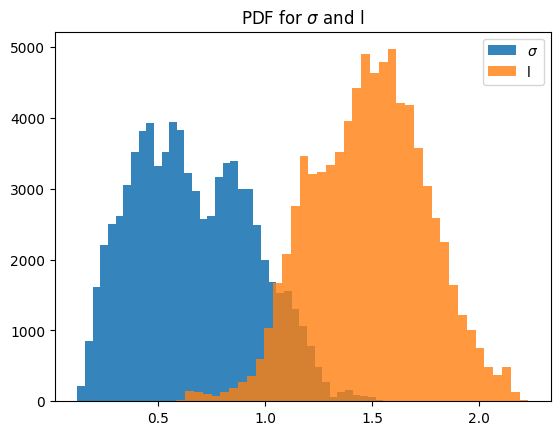

In [17]:
plt.hist(post_hyp[20000:,0], 40, alpha = 0.9, label='$\sigma$')
plt.hist(post_hyp[20000:,1], 40, alpha = 0.8, label = 'l')
plt.title('PDF for $\sigma$ and l')
plt.legend()
plt.show()